## Does not make sense

Cannot be finetuned with all 4 losses. The term 1 and term 4 are contradictory.

In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

C:\Users\ladwi\anaconda3\envs\deeplearning\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:5')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cuda:5


In [3]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
        
    def __getitem__(self, index):
        return self.X[index]
    
    def __len__(self):
        return len(self.X)

In [4]:
data_df = pd.read_csv("./../02_training/all_data_lake_modeling_in_time.csv")
time = data_df['time']
data_df = data_df.drop(columns=['time'])
data_df
display(data_df.head)

<bound method NDFrame.head of          depth  AirTemp_degC  Longwave_Wm-2  Latent_Wm-2  Sensible_Wm-2  \
0            1     -5.009902     530.969362   -14.309693     -21.535757   
1            2     -5.009902     530.969362   -14.309693     -21.535757   
2            3     -5.009902     530.969362   -14.309693     -21.535757   
3            4     -5.009902     530.969362   -14.309693     -21.535757   
4            5     -5.009902     530.969362   -14.309693     -21.535757   
...        ...           ...            ...          ...            ...   
1752345     46      3.859826     597.901711    25.170685      35.938051   
1752346     47      3.859826     597.901711    25.170685      35.938051   
1752347     48      3.859826     597.901711    25.170685      35.938051   
1752348     49      3.859826     597.901711    25.170685      35.938051   
1752349     50      3.859826     597.901711    25.170685      35.938051   

         Shortwave_Wm-2  lightExtinct_m-1  ShearVelocity_mS-1  \
0   

In [5]:
training_frac = 0.60
depth_steps = 50
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 35047
Number of training points: 1051400


# Normalizing Data

In [6]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

train_time = time[:n_obs]
test_time = time[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [7]:
m0_output_column_ix = [data_df.columns.get_loc(column) for column in ['temp_heat01']]

# Loading Models

In [8]:
m0_input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1','Area_m2', 
                 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice', 'temp_initial00']
m0_output_columns = ['temp_heat01']

m0_input_column_ix = [data_df.columns.get_loc(column) for column in m0_input_columns]
m0_output_column_ix = [data_df.columns.get_loc(column) for column in m0_output_columns]

m0_PATH =  f"./../02_training/saved_models/heating_model_time.pth"
m0_layers = [len(m0_input_columns), 32, 32, len(m0_output_columns)]

heating_model = MLP(m0_layers, activation="gelu")
m0_checkpoint = torch.load(m0_PATH, map_location=torch.device('cpu'))
heating_model.load_state_dict(m0_checkpoint)
heating_model = heating_model.to(device)

Initializing Network with Xavier Initialization..


## Heat Diffusion Model

In [9]:
m1_input_columns = ['depth', 'Area_m2', 'Uw',
                 'buoyancy', 'day_of_year', 'time_of_day',  'ice', 'snow', 'snowice','diffusivity', 'temp_total05']
m1_output_columns = ['temp_conv04']

m1_input_column_ix = [data_df.columns.get_loc(column) for column in m1_input_columns]
m1_output_column_ix = [data_df.columns.get_loc(column) for column in m1_output_columns]

m1_PATH = f"./../02_training/saved_models/diffusionconvection_model_time.pth"
m1_layers = [len(m1_input_columns), 32, 32, len(m1_output_columns)]

heat_diff_model = MLP(m1_layers, activation="gelu")
m1_checkpoint = torch.load(m1_PATH, map_location=torch.device('cpu'))
heat_diff_model.load_state_dict(m1_checkpoint)
heat_diff_model = heat_diff_model.to(device)

Initializing Network with Xavier Initialization..


## Mixing Model

# Convection Model

# Ice Model

In [10]:
m4_input_columns = ['depth', 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice',
                   'temp_heat01']
m4_output_columns = ['temp_total05']

m4_input_column_ix = [data_df.columns.get_loc(column) for column in m4_input_columns]
m4_output_column_ix = [data_df.columns.get_loc(column) for column in m4_output_columns]

m4_PATH = f"./../02_training/saved_models/ice_model_time.pth"
m4_layers = [len(m4_input_columns), 32, 32, len(m4_output_columns)]

ice_model = MLP(m4_layers, activation="gelu")
m4_checkpoint = torch.load(m4_PATH, map_location=torch.device('cpu'))
ice_model.load_state_dict(m4_checkpoint)
ice_model = ice_model.to(device)

Initializing Network with Xavier Initialization..


In [11]:
obs_temp_columns = ['obs_temp']

obs_temp_columns_ix = [data_df.columns.get_loc(column) for column in obs_temp_columns]

In [12]:
# depth_steps = 24
# train_data = np.reshape(train_data, (train_data.shape[0]//depth_steps, depth_steps, train_data.shape[1]))
# test_data = np.reshape(test_data, (test_data.shape[0]//depth_steps, depth_steps, test_data.shape[1]))

In [13]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

In [14]:
# Create data set
batch_size = 1000

#assert batch_size % 25 ==0, "Batchsize has to be multiple of 25" 

train_dataset = DataGenerator(train_data)
test_dataset = DataGenerator(test_data)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [15]:
print(train_data.shape)
print(test_data.shape)

(1051400, 45)
(700950, 45)


In [16]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

In [17]:
def compute_metrics(model, loader, input_columns, output_columns, train_mean, train_std):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(train_mean[output_columns]).to(device)
    std = torch.tensor(train_std[output_columns]).to(device)
    
    for x in iter(loader):
        inputs, target = x[:, input_columns].to(device).float(), x[:, output_columns].to(device).float()
        pred = model(inputs)
        target = target * std + mean
        pred = pred * std + mean
        y_.append(target)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    if y_.shape[1]==2:
        rmse_temp = rmse(y_[:,1], pred_[:,1])
        l2_error_temp = l2_error(y_[:,1], pred_[:,1])
    else:
        rmse_temp = rmse(y_[:,0], pred_[:,0])
        l2_error_temp = l2_error(y_[:,0], pred_[:,0])
        
    return rmse_temp, l2_error_temp

In [18]:
def get_rollout_predictions(heating_model, heat_diff_model, ice_model, loader, plot = True):    
    heating_model.eval()
    heat_diff_model.eval()
    ice_model.eval()

    mean = torch.tensor(train_mean[m1_output_column_ix]).float().to(device)
    std = torch.tensor(train_std[m1_output_column_ix]).float().to(device)

    m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
    m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

#     depthwise_y_pred = []
#     depthwise_y_true = []
    y_ = []
    y_obs_ = []
    pred_ = []
        
    rmse_models = np.zeros((len(loader), 5))
    for ix, x in enumerate(iter(loader)):
        x = x.to(device).float()
        
        m0_input = x[:, m0_input_column_ix]
            
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
            
        if plot:
            m0_y_true = x[:, m0_output_column_ix[0]] * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
            m0_y_pred = m0_pred * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 0] = rmse(m0_y_true.squeeze(), m0_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m0", rmse(m0_y_true.flatten(), m0_y_pred.flatten()))

        #model 2
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m0_pred], dim=-1)

        m4_pred = ice_model(m4_input)

        
        #print(m1_pred)
        
        if plot:
            m4_y_true = x[:, m4_output_column_ix[0]] * torch.tensor(train_std[m4_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m4_output_column_ix[0]]).to(device)
            m4_y_pred = m4_pred * torch.tensor(train_std[m4_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m4_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 1] = rmse(m4_y_true.squeeze(), m4_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m1", rmse(m4_y_true.flatten(), m4_y_pred.flatten()))


        #model 3
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m4_pred], dim=-1)
        m1_pred = heat_diff_model(m1_input)
            
        if plot:
            m1_y_true = x[:, m1_output_column_ix] * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
            m1_y_pred = m1_pred * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
            rmse_models[ix, 3] = rmse(m1_y_true.squeeze(), m1_y_pred.squeeze())
            print("RMSE of after m3", rmse(m1_y_true.flatten(), m1_y_pred.flatten()))



        y_true = x[:, m1_output_column_ix] * std + mean
        y_obs = x[:, obs_temp_columns_ix] * train_std[obs_temp_columns_ix[0]] + train_mean[obs_temp_columns_ix[0]]
        pred = m1_pred * std + mean
        
        y_.append(y_true)
        y_obs_.append(y_obs)
        pred_.append(pred)

    y_ = torch.cat(y_, dim=0)
    y_obs_ = torch.cat(y_obs_, dim=0)
    pred_ = torch.cat(pred_, dim=0) 
    
    #if plot:   
     #        rmse_models = rmse_models.mean(axis=0)
     #        plt.figure(figsize=(12,8))
     #        plt.plot(rmse_models[:, 0], label="RMSE after Heating Model")
     #        plt.plot(rmse_models[:, 1], label="RMSE after Heat-Diffusion Model")
     #        plt.plot(rmse_models[:, 2], label="RMSE after Mixing Model")
     #        plt.plot(rmse_models[:, 3], label="RMSE after Convection Model")
     #        plt.plot(rmse_models[:, 4], label="RMSE after Ice Model")
     #        plt.legend(loc="upper left", fontsize=12)
     #        plt.xlabel("Depth", fontsize=12)
     #        plt.ylabel("RMSE", fontsize=12)
     #        plt.grid("on", alpha=0.5)
     #        plt.show()
    
    return pred_, y_, y_obs_, rmse_models


In [19]:
def plot_output(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='Spectral_r', vmin=0., vmax=35.) # 'seismic'
    ax[0].set_ylabel("Depth", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    ax[0].collections[0].colorbar.set_label("Actual Temperature")
    
    sns.heatmap(y_pred.T, ax=ax[1], cmap='Spectral_r', vmin=0., vmax=35.)
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature")
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    
    ax[2].collections[0].colorbar.set_label("Absolute Error")
    plt.show()

# Rollout Results

## Training Results

In [20]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 0.0041027484
RMSE of after m1 0.016025735
RMSE of after m3 0.03712976
RMSE of after m0 0.006662367
RMSE of after m1 0.052950934
RMSE of after m3 0.16427867
RMSE of after m0 0.008104843
RMSE of after m1 0.028474016
RMSE of after m3 0.09101351
RMSE of after m0 0.0076912576
RMSE of after m1 0.020512382
RMSE of after m3 0.033429414
RMSE of after m0 0.007948776
RMSE of after m1 0.018048972
RMSE of after m3 0.027177742
RMSE of after m0 0.007042731
RMSE of after m1 0.015575844
RMSE of after m3 0.023722814
RMSE of after m0 0.005781268
RMSE of after m1 0.013841938
RMSE of after m3 0.021632062
RMSE of after m0 0.008311805
RMSE of after m1 0.018056948
RMSE of after m3 0.021682486
RMSE of after m0 0.0074767084
RMSE of after m1 0.014158648
RMSE of after m3 0.018619195
RMSE of after m0 0.0052842437
RMSE of after m1 0.0102235135
RMSE of after m3 0.013258893
RMSE of after m0 0.0054681567
RMSE of after m1 0.011589471
RMSE of after m3 0.014476499
RMSE of after m0 0.005552288
RMSE of aft

RMSE of after m1 0.01444304
RMSE of after m3 0.020389859
RMSE of after m0 0.006364252
RMSE of after m1 0.025122792
RMSE of after m3 0.039674833
RMSE of after m0 0.006962873
RMSE of after m1 0.022101153
RMSE of after m3 0.03755638
RMSE of after m0 0.008553705
RMSE of after m1 0.021224901
RMSE of after m3 0.02577042
RMSE of after m0 0.009473011
RMSE of after m1 0.023761353
RMSE of after m3 0.035390284
RMSE of after m0 0.007673385
RMSE of after m1 0.014329394
RMSE of after m3 0.017466027
RMSE of after m0 0.008071567
RMSE of after m1 0.02001983
RMSE of after m3 0.02104471
RMSE of after m0 0.016749207
RMSE of after m1 0.01876245
RMSE of after m3 0.0201474
RMSE of after m0 0.011784869
RMSE of after m1 0.018152822
RMSE of after m3 0.023894256
RMSE of after m0 0.010276758
RMSE of after m1 0.022149669
RMSE of after m3 0.03445687
RMSE of after m0 0.0063869758
RMSE of after m1 0.0348744
RMSE of after m3 0.06883827
RMSE of after m0 0.0053895223
RMSE of after m1 0.015323367
RMSE of after m3 0.06408

RMSE of after m3 0.04132939
RMSE of after m0 0.008644735
RMSE of after m1 0.008384251
RMSE of after m3 0.029434066
RMSE of after m0 0.0059869755
RMSE of after m1 0.0060539185
RMSE of after m3 0.033948343
RMSE of after m0 0.005331048
RMSE of after m1 0.0056290505
RMSE of after m3 0.026803585
RMSE of after m0 0.0046564196
RMSE of after m1 0.005721294
RMSE of after m3 0.02064819
RMSE of after m0 0.0048933527
RMSE of after m1 0.0058518266
RMSE of after m3 0.02252849
RMSE of after m0 0.0062311566
RMSE of after m1 0.006829465
RMSE of after m3 0.026414428
RMSE of after m0 0.005574899
RMSE of after m1 0.006416656
RMSE of after m3 0.02225636
RMSE of after m0 0.004265769
RMSE of after m1 0.0051730433
RMSE of after m3 0.016809892
RMSE of after m0 0.00490305
RMSE of after m1 0.0056332736
RMSE of after m3 0.020670757
RMSE of after m0 0.0044159666
RMSE of after m1 0.0059499047
RMSE of after m3 0.017386198
RMSE of after m0 0.0046319054
RMSE of after m1 0.0061375303
RMSE of after m3 0.019990472
RMSE o

RMSE of after m1 0.0061231176
RMSE of after m3 0.016748013
RMSE of after m0 0.004424912
RMSE of after m1 0.0060847793
RMSE of after m3 0.013453295
RMSE of after m0 0.0064859125
RMSE of after m1 0.007879317
RMSE of after m3 0.019367052
RMSE of after m0 0.006179565
RMSE of after m1 0.0074604633
RMSE of after m3 0.018048143
RMSE of after m0 0.0068496726
RMSE of after m1 0.00815062
RMSE of after m3 0.021438796
RMSE of after m0 0.009743109
RMSE of after m1 0.010253711
RMSE of after m3 0.08002618
RMSE of after m0 0.009699121
RMSE of after m1 0.010010225
RMSE of after m3 0.07211728
RMSE of after m0 0.005392985
RMSE of after m1 0.006491209
RMSE of after m3 0.025883479
RMSE of after m0 0.004792357
RMSE of after m1 0.005914076
RMSE of after m3 0.024343193
RMSE of after m0 0.0053705694
RMSE of after m1 0.0068043075
RMSE of after m3 0.02154389
RMSE of after m0 0.0071543125
RMSE of after m1 0.008470747
RMSE of after m3 0.02091235
RMSE of after m0 0.004727808
RMSE of after m1 0.006316045
RMSE of aft

RMSE of after m3 0.017242024
RMSE of after m0 0.0065613766
RMSE of after m1 0.006753407
RMSE of after m3 0.010317832
RMSE of after m0 0.0065200236
RMSE of after m1 0.006091498
RMSE of after m3 0.009945235
RMSE of after m0 0.006576419
RMSE of after m1 0.0059381747
RMSE of after m3 0.012029077
RMSE of after m0 0.006682123
RMSE of after m1 0.0060942443
RMSE of after m3 0.009569925
RMSE of after m0 0.0065317736
RMSE of after m1 0.005595829
RMSE of after m3 0.009795961
RMSE of after m0 0.0075183255
RMSE of after m1 0.0099845
RMSE of after m3 0.011160394
RMSE of after m0 0.008588995
RMSE of after m1 0.01495589
RMSE of after m3 0.018302443
RMSE of after m0 0.008078946
RMSE of after m1 0.01509529
RMSE of after m3 0.016769316
RMSE of after m0 0.007867193
RMSE of after m1 0.015688436
RMSE of after m3 0.019971024
RMSE of after m0 0.015799616
RMSE of after m1 0.015170049
RMSE of after m3 0.027532155
RMSE of after m0 0.0142169
RMSE of after m1 0.01616048
RMSE of after m3 0.024981277
RMSE of after m

RMSE of after m0 0.015487842
RMSE of after m1 0.034416478
RMSE of after m3 0.04156844
RMSE of after m0 0.014712313
RMSE of after m1 0.032730497
RMSE of after m3 0.035987526
RMSE of after m0 0.013658291
RMSE of after m1 0.029886816
RMSE of after m3 0.022759147
RMSE of after m0 0.015029059
RMSE of after m1 0.041707143
RMSE of after m3 0.03698624
RMSE of after m0 0.014606113
RMSE of after m1 0.03016337
RMSE of after m3 0.032173313
RMSE of after m0 0.01686546
RMSE of after m1 0.03192882
RMSE of after m3 0.024885975
RMSE of after m0 0.017167049
RMSE of after m1 0.028075416
RMSE of after m3 0.02401409
RMSE of after m0 0.016443288
RMSE of after m1 0.028258504
RMSE of after m3 0.024601439
RMSE of after m0 0.006393435
RMSE of after m1 0.009057318
RMSE of after m3 0.013571651
RMSE of after m0 0.0060197976
RMSE of after m1 0.007937574
RMSE of after m3 0.016800463
RMSE of after m0 0.005813044
RMSE of after m1 0.006582472
RMSE of after m3 0.023925455
RMSE of after m0 0.0083922185
RMSE of after m1 0

RMSE of after m1 0.0072630364
RMSE of after m3 0.0352427
RMSE of after m0 0.005023116
RMSE of after m1 0.007920022
RMSE of after m3 0.02354186
RMSE of after m0 0.00919418
RMSE of after m1 0.010157422
RMSE of after m3 0.063535534
RMSE of after m0 0.006056977
RMSE of after m1 0.006700815
RMSE of after m3 0.02761221
RMSE of after m0 0.006852794
RMSE of after m1 0.00647261
RMSE of after m3 0.030086631
RMSE of after m0 0.00710886
RMSE of after m1 0.0066021807
RMSE of after m3 0.036383055
RMSE of after m0 0.0053519807
RMSE of after m1 0.0069312896
RMSE of after m3 0.030527845
RMSE of after m0 0.004950428
RMSE of after m1 0.0065227384
RMSE of after m3 0.036000624
RMSE of after m0 0.0044408175
RMSE of after m1 0.0056738546
RMSE of after m3 0.018560084
RMSE of after m0 0.013630169
RMSE of after m1 0.014490961
RMSE of after m3 0.091313936
RMSE of after m0 0.019433154
RMSE of after m1 0.020611284
RMSE of after m3 0.08066693
RMSE of after m0 0.00461153
RMSE of after m1 0.005719444
RMSE of after m3

RMSE of after m0 0.00528056
RMSE of after m1 0.006787452
RMSE of after m3 0.023360802
RMSE of after m0 0.015211197
RMSE of after m1 0.015561397
RMSE of after m3 0.045803737
RMSE of after m0 0.0058867694
RMSE of after m1 0.007182165
RMSE of after m3 0.020559944
RMSE of after m0 0.005932874
RMSE of after m1 0.007299014
RMSE of after m3 0.017479343
RMSE of after m0 0.0073596295
RMSE of after m1 0.008268875
RMSE of after m3 0.020473821
RMSE of after m0 0.0056470637
RMSE of after m1 0.0069211973
RMSE of after m3 0.014693908
RMSE of after m0 0.0056964993
RMSE of after m1 0.0065364647
RMSE of after m3 0.021373319
RMSE of after m0 0.0057864804
RMSE of after m1 0.006298496
RMSE of after m3 0.023584202
RMSE of after m0 0.0067988527
RMSE of after m1 0.0076576257
RMSE of after m3 0.038917474
RMSE of after m0 0.007397525
RMSE of after m1 0.007627835
RMSE of after m3 0.030371401
RMSE of after m0 0.007891589
RMSE of after m1 0.007627985
RMSE of after m3 0.04417463
RMSE of after m0 0.005356214
RMSE of

RMSE of after m0 0.007291898
RMSE of after m1 0.015964892
RMSE of after m3 0.017288627
RMSE of after m0 0.006109041
RMSE of after m1 0.014285197
RMSE of after m3 0.019117374
RMSE of after m0 0.0054096137
RMSE of after m1 0.0118114175
RMSE of after m3 0.014941523
RMSE of after m0 0.0058878744
RMSE of after m1 0.012453103
RMSE of after m3 0.017275032
RMSE of after m0 0.006117646
RMSE of after m1 0.0126378825
RMSE of after m3 0.018867288
RMSE of after m0 0.0063299965
RMSE of after m1 0.014096912
RMSE of after m3 0.032698154
RMSE of after m0 0.008067218
RMSE of after m1 0.016208813
RMSE of after m3 0.030639589
RMSE of after m0 0.0056790155
RMSE of after m1 0.013167526
RMSE of after m3 0.018354725
RMSE of after m0 0.005849534
RMSE of after m1 0.013892198
RMSE of after m3 0.016597306
RMSE of after m0 0.0063323425
RMSE of after m1 0.016250573
RMSE of after m3 0.022056786
RMSE of after m0 0.005804048
RMSE of after m1 0.010690537
RMSE of after m3 0.016503092
RMSE of after m0 0.0065023447
RMSE o

RMSE of after m0 0.011032508
RMSE of after m1 0.01772615
RMSE of after m3 0.033071388
RMSE of after m0 0.011299483
RMSE of after m1 0.019142402
RMSE of after m3 0.028786756
RMSE of after m0 0.01039747
RMSE of after m1 0.020716414
RMSE of after m3 0.02950109
RMSE of after m0 0.010224589
RMSE of after m1 0.020150755
RMSE of after m3 0.029959803
RMSE of after m0 0.010156725
RMSE of after m1 0.020062864
RMSE of after m3 0.02832089
RMSE of after m0 0.010375062
RMSE of after m1 0.026681334
RMSE of after m3 0.035656076
RMSE of after m0 0.010885773
RMSE of after m1 0.029624812
RMSE of after m3 0.04123739
RMSE of after m0 0.011399232
RMSE of after m1 0.031645738
RMSE of after m3 0.045756105
RMSE of after m0 0.011101814
RMSE of after m1 0.01949862
RMSE of after m3 0.035213612
RMSE of after m0 0.010343949
RMSE of after m1 0.019803902
RMSE of after m3 0.03313528
RMSE of after m0 0.010311926
RMSE of after m1 0.019718496
RMSE of after m3 0.03318968
RMSE of after m0 0.011013194
RMSE of after m1 0.019

The RMSEs after each modelling stage: [0.00818353 0.01301153 0.         0.03038281 0.        ]


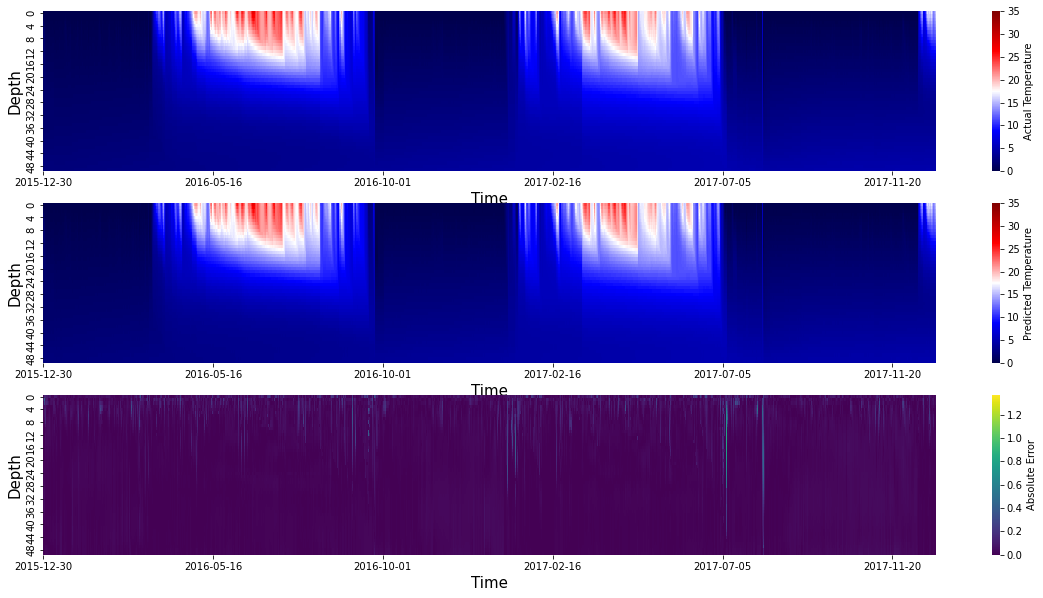

In [21]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

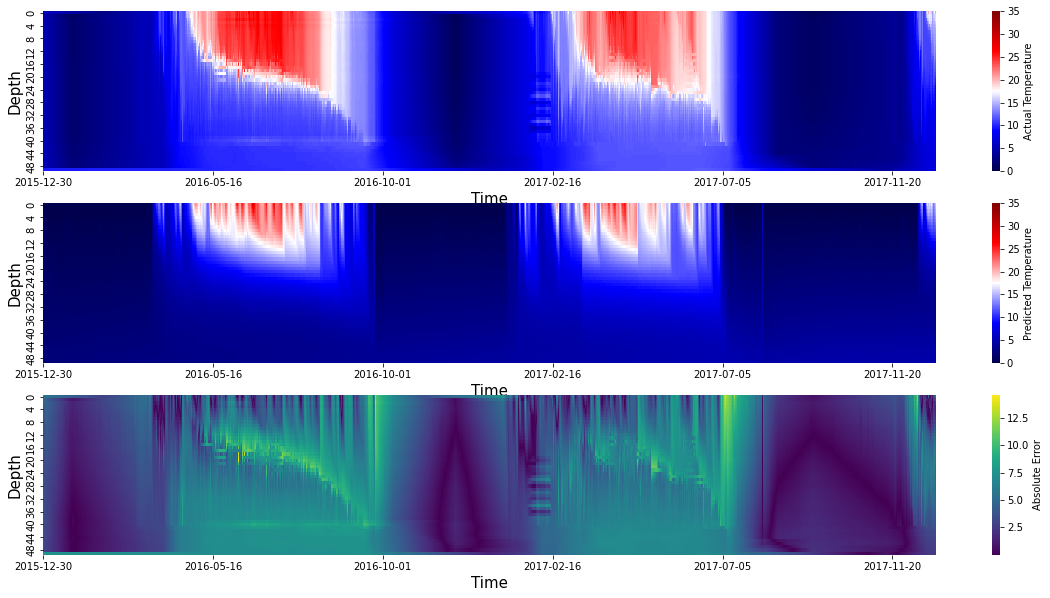

In [22]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

## Test Results

In [23]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model,heat_diff_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.0059419116
RMSE of after m1 0.006902804
RMSE of after m3 0.015222779
RMSE of after m0 0.007157667
RMSE of after m1 0.007972541
RMSE of after m3 0.01821663
RMSE of after m0 0.0047542206
RMSE of after m1 0.005939046
RMSE of after m3 0.012573201
RMSE of after m0 0.0051618326
RMSE of after m1 0.0064778053
RMSE of after m3 0.014327755
RMSE of after m0 0.005379781
RMSE of after m1 0.006945205
RMSE of after m3 0.017386705
RMSE of after m0 0.005166138
RMSE of after m1 0.00688493
RMSE of after m3 0.02093013
RMSE of after m0 0.005269972
RMSE of after m1 0.0065093883
RMSE of after m3 0.027910296
RMSE of after m0 0.0053153355
RMSE of after m1 0.006314988
RMSE of after m3 0.018185666
RMSE of after m0 0.0046447846
RMSE of after m1 0.005735461
RMSE of after m3 0.017641397
RMSE of after m0 0.004503654
RMSE of after m1 0.0058614574
RMSE of after m3 0.018424124
RMSE of after m0 0.007767791
RMSE of after m1 0.008159259
RMSE of after m3 0.046150662
RMSE of after m0 0.005861118
RMSE of a

RMSE of after m1 0.0072342292
RMSE of after m3 0.034825526
RMSE of after m0 0.005456977
RMSE of after m1 0.0063139503
RMSE of after m3 0.058089573
RMSE of after m0 0.005581667
RMSE of after m1 0.007126527
RMSE of after m3 0.035123814
RMSE of after m0 0.004872837
RMSE of after m1 0.0060641957
RMSE of after m3 0.012670371
RMSE of after m0 0.012430295
RMSE of after m1 0.013115964
RMSE of after m3 0.05563815
RMSE of after m0 0.00823705
RMSE of after m1 0.008753587
RMSE of after m3 0.030114358
RMSE of after m0 0.0073705977
RMSE of after m1 0.007822344
RMSE of after m3 0.029395876
RMSE of after m0 0.007646391
RMSE of after m1 0.0077457936
RMSE of after m3 0.032405395
RMSE of after m0 0.010148327
RMSE of after m1 0.010304002
RMSE of after m3 0.047406808
RMSE of after m0 0.0060831583
RMSE of after m1 0.006829344
RMSE of after m3 0.029656077
RMSE of after m0 0.010573889
RMSE of after m1 0.010777882
RMSE of after m3 0.040295653
RMSE of after m0 0.0067374343
RMSE of after m1 0.0075010043
RMSE of 

RMSE of after m1 0.025144868
RMSE of after m3 0.039455812
RMSE of after m0 0.0061294483
RMSE of after m1 0.026278568
RMSE of after m3 0.04344722
RMSE of after m0 0.0068743955
RMSE of after m1 0.027985027
RMSE of after m3 0.039966956
RMSE of after m0 0.0061990884
RMSE of after m1 0.026365085
RMSE of after m3 0.037424657
RMSE of after m0 0.0060292934
RMSE of after m1 0.025042884
RMSE of after m3 0.031059071
RMSE of after m0 0.0059151067
RMSE of after m1 0.02845197
RMSE of after m3 0.037960827
RMSE of after m0 0.005905574
RMSE of after m1 0.037929695
RMSE of after m3 0.0468393
RMSE of after m0 0.006334074
RMSE of after m1 0.036127497
RMSE of after m3 0.06882783
RMSE of after m0 0.00627879
RMSE of after m1 0.027393384
RMSE of after m3 0.06112694
RMSE of after m0 0.0060770637
RMSE of after m1 0.027056566
RMSE of after m3 0.05851997
RMSE of after m0 0.005619161
RMSE of after m1 0.027193282
RMSE of after m3 0.055209473
RMSE of after m0 0.0056723664
RMSE of after m1 0.02644495
RMSE of after m3

RMSE of after m0 0.06418137
RMSE of after m1 0.20601286
RMSE of after m3 0.23032227
RMSE of after m0 0.054123033
RMSE of after m1 0.20430648
RMSE of after m3 0.20678607
RMSE of after m0 0.048772503
RMSE of after m1 0.20269486
RMSE of after m3 0.22470601
RMSE of after m0 0.057070404
RMSE of after m1 0.22015743
RMSE of after m3 0.2731581
RMSE of after m0 0.081837445
RMSE of after m1 0.21378964
RMSE of after m3 0.28164926
RMSE of after m0 0.08383038
RMSE of after m1 0.21712008
RMSE of after m3 0.2802331
RMSE of after m0 0.07358685
RMSE of after m1 0.22259748
RMSE of after m3 0.27608928
RMSE of after m0 0.06884054
RMSE of after m1 0.22575627
RMSE of after m3 0.25356463
RMSE of after m0 0.06593164
RMSE of after m1 0.22944355
RMSE of after m3 0.24763803
RMSE of after m0 0.058176953
RMSE of after m1 0.22309679
RMSE of after m3 0.21201558
RMSE of after m0 0.05369765
RMSE of after m1 0.22300723
RMSE of after m3 0.22286947
RMSE of after m0 0.055157162
RMSE of after m1 0.23921883
RMSE of after m3

RMSE of after m1 0.006419514
RMSE of after m3 0.056570623
RMSE of after m0 0.0052316515
RMSE of after m1 0.006476621
RMSE of after m3 0.019883014
RMSE of after m0 0.0038999375
RMSE of after m1 0.0050414153
RMSE of after m3 0.015626425
RMSE of after m0 0.0041096425
RMSE of after m1 0.005642016
RMSE of after m3 0.01645891
RMSE of after m0 0.004508008
RMSE of after m1 0.0057653077
RMSE of after m3 0.018095847
RMSE of after m0 0.0055977283
RMSE of after m1 0.006018032
RMSE of after m3 0.021428062
RMSE of after m0 0.0054250015
RMSE of after m1 0.006210314
RMSE of after m3 0.01594673
RMSE of after m0 0.0072969673
RMSE of after m1 0.0076831738
RMSE of after m3 0.04145393
RMSE of after m0 0.0047151186
RMSE of after m1 0.005281022
RMSE of after m3 0.025037475
RMSE of after m0 0.0057924474
RMSE of after m1 0.0065830564
RMSE of after m3 0.039478384
RMSE of after m0 0.0075004254
RMSE of after m1 0.008431086
RMSE of after m3 0.029601997
RMSE of after m0 0.0045897337
RMSE of after m1 0.0053947708
RM

RMSE of after m1 0.0060965903
RMSE of after m3 0.035249226
RMSE of after m0 0.008330602
RMSE of after m1 0.008205334
RMSE of after m3 0.047652982
RMSE of after m0 0.006344779
RMSE of after m1 0.007346253
RMSE of after m3 0.032466207
RMSE of after m0 0.016740473
RMSE of after m1 0.016645346
RMSE of after m3 0.07208399
RMSE of after m0 0.0056304876
RMSE of after m1 0.006660465
RMSE of after m3 0.021248948
RMSE of after m0 0.0045621004
RMSE of after m1 0.006383826
RMSE of after m3 0.021785958
RMSE of after m0 0.0042897114
RMSE of after m1 0.0059754835
RMSE of after m3 0.015812306
RMSE of after m0 0.0044139456
RMSE of after m1 0.0061234683
RMSE of after m3 0.015425847
RMSE of after m0 0.0081356885
RMSE of after m1 0.009088938
RMSE of after m3 0.03029964
RMSE of after m0 0.011741213
RMSE of after m1 0.0116083985
RMSE of after m3 0.04774734
RMSE of after m0 0.005671197
RMSE of after m1 0.0066172313
RMSE of after m3 0.024017675
RMSE of after m0 0.0047484566
RMSE of after m1 0.0058001997
RMSE 

RMSE of after m3 0.08133652
RMSE of after m0 0.0062810825
RMSE of after m1 0.06407485
RMSE of after m3 0.08075668
RMSE of after m0 0.006036525
RMSE of after m1 0.06469597
RMSE of after m3 0.08434965
RMSE of after m0 0.008506412
RMSE of after m1 0.066326216
RMSE of after m3 0.07366795
RMSE of after m0 0.006566071
RMSE of after m1 0.056481306
RMSE of after m3 0.06706009
RMSE of after m0 0.0059708436
RMSE of after m1 0.056317084
RMSE of after m3 0.064228736
RMSE of after m0 0.005935094
RMSE of after m1 0.05544366
RMSE of after m3 0.068574466
RMSE of after m0 0.006756567
RMSE of after m1 0.057400335
RMSE of after m3 0.057780176
RMSE of after m0 0.006604133
RMSE of after m1 0.05817081
RMSE of after m3 0.056423407
RMSE of after m0 0.00592192
RMSE of after m1 0.05993512
RMSE of after m3 0.056155384
RMSE of after m0 0.0065572434
RMSE of after m1 0.060046744
RMSE of after m3 0.06579502
RMSE of after m0 0.005875742
RMSE of after m1 0.060521565
RMSE of after m3 0.062253438
RMSE of after m0 0.0055

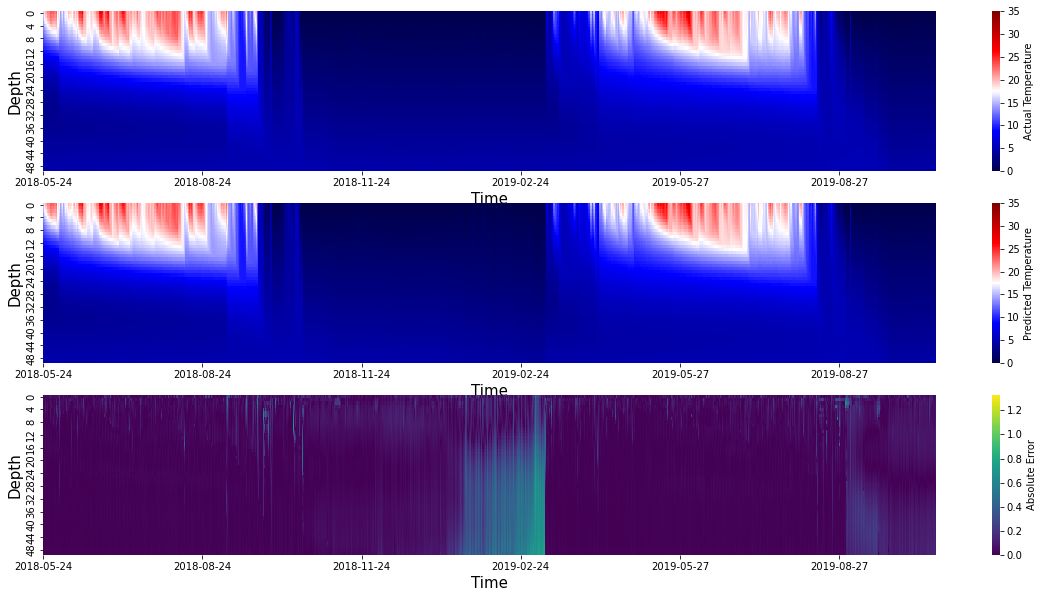

In [24]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

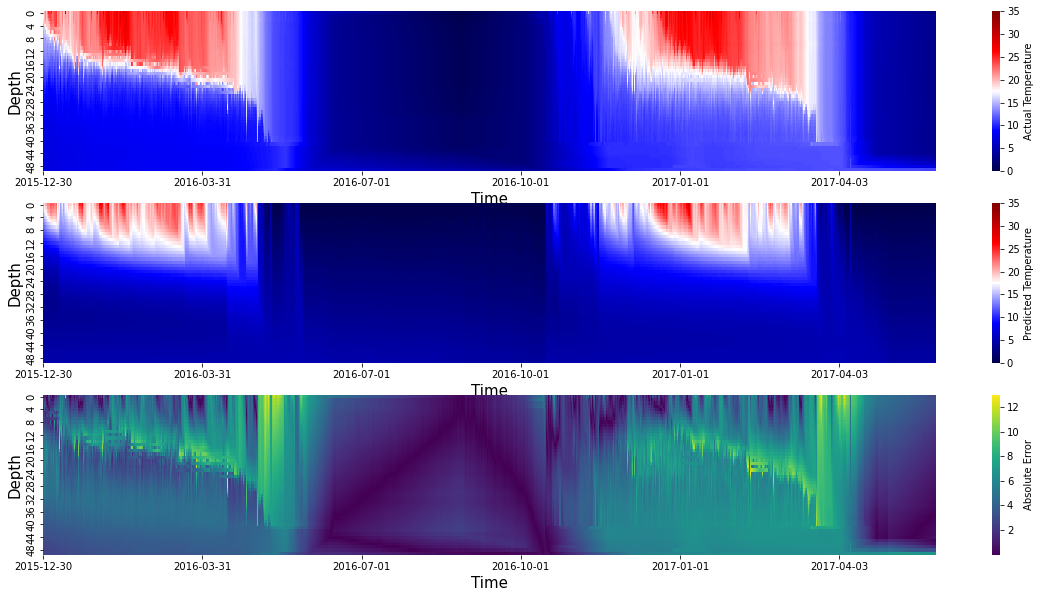

In [25]:
plot_output(test_y_pred, test_y_obs, depth_steps, train_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [26]:
train_rmse, train_l2_err = compute_metrics( heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.03576070104084009, Train L2 Error: 0.004980941251968362
Test RMSE: 0.11636405278755327, Train L2 Error: 0.01420615134310525


## Mixing Model

## Convection Model

## Ice Model

In [27]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.011916424143528238, Train L2 Error: 0.0016585208599914363
Test RMSE: 0.07897739329873596, Train L2 Error: 0.0096342043173161


# Finetuning

In [28]:
lr = 1e-5
# decay_rate = 0.1
# decay_steps = 500

params = list(heating_model.parameters()) + list(heat_diff_model.parameters())+ list(ice_model.parameters())

optimizer = torch.optim.Adam(params, lr=lr, 
                             betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

# Freeze model weights

In [29]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [30]:
#freeze_model(heating_model)
freeze_model(heating_model)
unfreeze_model(heat_diff_model)
freeze_model(ice_model)


# Finetuning on Observed Temperature

In [31]:
heating_model.train()
heat_diff_model.train()
ice_model.train()

n_epochs = 1000

# mean and standard dev of "temp_total04" of model 4 output
mean_out1 = torch.tensor(train_mean[m1_output_column_ix[0]]).float().to(device)
std_out1 = torch.tensor(train_std[m1_output_column_ix[0]]).float().to(device)

mean_obs = torch.tensor(train_mean[obs_temp_columns_ix[0]]).float().to(device)
std_obs = torch.tensor(train_std[obs_temp_columns_ix[0]]).float().to(device)

# mean and standard dev of "input_temp" of model 1 input
m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

train_loss = []
LOSS_m0 = []
LOSS_m1 = []
LOSS_m4 = []

for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    loss_epoch_m0 = 0
    loss_epoch_m1 = 0
    loss_epoch_m4 = 0
    for ix, x in enumerate(iter(train_loader)):
        x = x.to(device).float()
        optimizer.zero_grad()
        
      #  m1_input = x[:, m1_input_column_ix]
        m0_input = x[:, m0_input_column_ix]
        
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
        loss_m0 = criterion(m0_pred, x[:, m0_output_column_ix])

        #model 1
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m0_pred], dim=-1)
        # m1_pred = heat_diff_model(m1_input)
        
        m4_pred = ice_model(m4_input)
        loss_m4 = criterion(m4_pred, x[:, m4_output_column_ix])
        
        #m1_pred = heat_diff_model(m1_input) #predicts diff and temp
        #m1_pred_temp = m1_pred[:,1:2]
            
        #loss_m1 = criterion(m1_pred_temp, x[:, m1_output_column_ix[1]].unsqueeze(1))

        #model 3
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m4_pred], dim=-1)
        m1_pred = heat_diff_model(m1_input)

        
        obs_temp_true = x[:, obs_temp_columns_ix] * std_obs + mean_obs
        obs_temp_true_norm = (obs_temp_true - mean_out1)/std_out1
        
        loss_m1 = criterion(m1_pred, obs_temp_true_norm)

        #loss = (loss_m0 + loss_m1 + loss_m2 + loss_m3 + loss_m4)
        
        loss = loss_m1
        
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss.item()
        loss_epoch_m0 += loss_m0.item()
        loss_epoch_m1 += loss_m1.item()
        loss_epoch_m4 += loss_m4.item()
    
    loss_epoch = loss_epoch/len(train_loader)
    loss_epoch_m0 = loss_epoch_m0/len(train_loader)
    loss_epoch_m1 = loss_epoch_m1/len(train_loader)
    loss_epoch_m4 = loss_epoch_m4/len(train_loader)
    
    train_loss.append(loss_epoch)
    LOSS_m0.append(loss_epoch_m0)
    LOSS_m1.append(loss_epoch_m1)
    LOSS_m4.append(loss_epoch_m4)
    if it % 50 == 0:
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Loss m0: {LOSS_m0[-1]}, Loss m1: {LOSS_m1[-1]}, Loss m4: {LOSS_m4[-1]}")
    
    #plot the loss_m1, m2


  0%|          | 1/1000 [00:05<1:38:40,  5.93s/it]

Epoch : 0, Train_loss: 0.8764681399626367, Loss m0: 3.55258023806422e-06, Loss m1: 0.8764681399626367, Loss m4: 9.694443548180119e-06


  5%|▌         | 51/1000 [05:07<1:31:37,  5.79s/it]

Epoch : 50, Train_loss: 0.09232857849443607, Loss m0: 3.55258023806422e-06, Loss m1: 0.09232857849443607, Loss m4: 9.694443548180119e-06


 10%|█         | 101/1000 [09:54<1:26:44,  5.79s/it]

Epoch : 100, Train_loss: 0.0759499323050387, Loss m0: 3.55258023806422e-06, Loss m1: 0.0759499323050387, Loss m4: 9.694443548180119e-06


 15%|█▌        | 151/1000 [14:49<1:21:17,  5.74s/it]

Epoch : 150, Train_loss: 0.06545066745675562, Loss m0: 3.55258023806422e-06, Loss m1: 0.06545066745675562, Loss m4: 9.694443548180119e-06


 20%|██        | 201/1000 [19:39<1:16:01,  5.71s/it]

Epoch : 200, Train_loss: 0.05861210546207512, Loss m0: 3.55258023806422e-06, Loss m1: 0.05861210546207512, Loss m4: 9.694443548180119e-06


 25%|██▌       | 251/1000 [24:24<1:10:57,  5.68s/it]

Epoch : 250, Train_loss: 0.05479865934688265, Loss m0: 3.55258023806422e-06, Loss m1: 0.05479865934688265, Loss m4: 9.694443548180119e-06


 30%|███       | 301/1000 [29:11<1:06:38,  5.72s/it]

Epoch : 300, Train_loss: 0.05231344083478115, Loss m0: 3.55258023806422e-06, Loss m1: 0.05231344083478115, Loss m4: 9.694443548180119e-06


 35%|███▌      | 351/1000 [34:12<1:06:41,  6.17s/it]

Epoch : 350, Train_loss: 0.050367852700157124, Loss m0: 3.55258023806422e-06, Loss m1: 0.050367852700157124, Loss m4: 9.694443548180119e-06


 40%|████      | 401/1000 [39:10<1:01:27,  6.16s/it]

Epoch : 400, Train_loss: 0.04871000370901333, Loss m0: 3.55258023806422e-06, Loss m1: 0.04871000370901333, Loss m4: 9.694443548180119e-06


 45%|████▌     | 451/1000 [44:05<53:13,  5.82s/it]  

Epoch : 450, Train_loss: 0.047233642997422005, Loss m0: 3.55258023806422e-06, Loss m1: 0.047233642997422005, Loss m4: 9.694443548180119e-06


 50%|█████     | 501/1000 [48:54<47:25,  5.70s/it]

Epoch : 500, Train_loss: 0.045897486691138294, Loss m0: 3.55258023806422e-06, Loss m1: 0.045897486691138294, Loss m4: 9.694443548180119e-06


 55%|█████▌    | 551/1000 [53:40<42:35,  5.69s/it]

Epoch : 550, Train_loss: 0.044670349004025084, Loss m0: 3.55258023806422e-06, Loss m1: 0.044670349004025084, Loss m4: 9.694443548180119e-06


 60%|██████    | 601/1000 [58:27<37:48,  5.69s/it]

Epoch : 600, Train_loss: 0.04351698031415278, Loss m0: 3.55258023806422e-06, Loss m1: 0.04351698031415278, Loss m4: 9.694443548180119e-06


 65%|██████▌   | 651/1000 [1:03:13<33:21,  5.74s/it]

Epoch : 650, Train_loss: 0.042419391451846145, Loss m0: 3.55258023806422e-06, Loss m1: 0.042419391451846145, Loss m4: 9.694443548180119e-06


 70%|███████   | 701/1000 [1:08:00<28:38,  5.75s/it]

Epoch : 700, Train_loss: 0.0413744939073297, Loss m0: 3.55258023806422e-06, Loss m1: 0.0413744939073297, Loss m4: 9.694443548180119e-06


 75%|███████▌  | 751/1000 [1:12:52<23:59,  5.78s/it]

Epoch : 750, Train_loss: 0.040383011952552506, Loss m0: 3.55258023806422e-06, Loss m1: 0.040383011952552506, Loss m4: 9.694443548180119e-06


 80%|████████  | 801/1000 [1:17:50<19:36,  5.91s/it]

Epoch : 800, Train_loss: 0.03944444599248887, Loss m0: 3.55258023806422e-06, Loss m1: 0.03944444599248887, Loss m4: 9.694443548180119e-06


 85%|████████▌ | 851/1000 [1:22:54<15:18,  6.17s/it]

Epoch : 850, Train_loss: 0.03855901012332586, Loss m0: 3.55258023806422e-06, Loss m1: 0.03855901012332586, Loss m4: 9.694443548180119e-06


 90%|█████████ | 901/1000 [1:28:19<11:12,  6.79s/it]

Epoch : 900, Train_loss: 0.037726733528569825, Loss m0: 3.55258023806422e-06, Loss m1: 0.037726733528569825, Loss m4: 9.694443548180119e-06


 95%|█████████▌| 951/1000 [1:33:30<06:07,  7.49s/it]

Epoch : 950, Train_loss: 0.03694851500499629, Loss m0: 3.55258023806422e-06, Loss m1: 0.03694851500499629, Loss m4: 9.694443548180119e-06


100%|██████████| 1000/1000 [1:38:43<00:00,  5.92s/it]


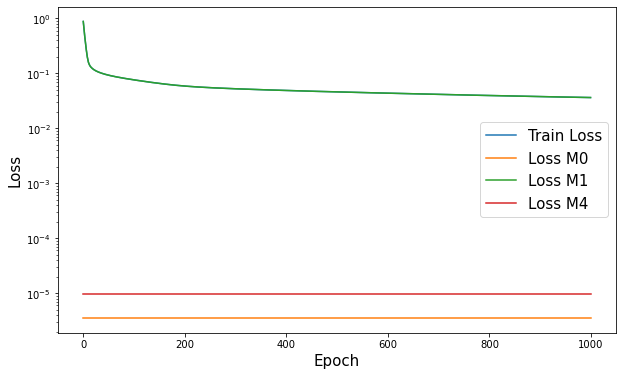

In [32]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label = "Train Loss")
plt.plot(LOSS_m0, label = "Loss M0")
plt.plot(LOSS_m1, label = "Loss M1")
#plt.plot(LOSS_m2, label = "Loss M2")
#plt.plot(LOSS_m3, label = "Loss M3")
plt.plot(LOSS_m4, label = "Loss M4")
plt.ylabel("Loss", fontsize=15)
plt.xlabel("Epoch", fontsize=15)
plt.yscale("log")
plt.legend(fontsize=15)
plt.show()

# Rollout Evaluation After FineTuning

In [33]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 0.0041027484
RMSE of after m1 0.016025735
RMSE of after m3 6.00707
RMSE of after m0 0.006662367
RMSE of after m1 0.052950934
RMSE of after m3 5.1478543
RMSE of after m0 0.008104843
RMSE of after m1 0.028474016
RMSE of after m3 4.2354794
RMSE of after m0 0.0076912576
RMSE of after m1 0.020512382
RMSE of after m3 3.6979504
RMSE of after m0 0.007948776
RMSE of after m1 0.018048972
RMSE of after m3 3.6047475
RMSE of after m0 0.007042731
RMSE of after m1 0.015575844
RMSE of after m3 3.4761207
RMSE of after m0 0.005781268
RMSE of after m1 0.013841938
RMSE of after m3 3.3370326
RMSE of after m0 0.008311805
RMSE of after m1 0.018056948
RMSE of after m3 3.2797167
RMSE of after m0 0.0074767084
RMSE of after m1 0.014158648
RMSE of after m3 3.2470915
RMSE of after m0 0.0052842437
RMSE of after m1 0.0102235135
RMSE of after m3 3.1511552
RMSE of after m0 0.0054681567
RMSE of after m1 0.011589471
RMSE of after m3 3.131623
RMSE of after m0 0.005552288
RMSE of after m1 0.012590096
RMSE

RMSE of after m1 0.014329394
RMSE of after m3 3.4590359
RMSE of after m0 0.008071567
RMSE of after m1 0.02001983
RMSE of after m3 3.5049803
RMSE of after m0 0.016749207
RMSE of after m1 0.01876245
RMSE of after m3 3.373006
RMSE of after m0 0.011784869
RMSE of after m1 0.018152822
RMSE of after m3 3.7802942
RMSE of after m0 0.010276758
RMSE of after m1 0.022149669
RMSE of after m3 3.6031075
RMSE of after m0 0.0063869758
RMSE of after m1 0.0348744
RMSE of after m3 3.7843876
RMSE of after m0 0.0053895223
RMSE of after m1 0.015323367
RMSE of after m3 3.98918
RMSE of after m0 0.016468747
RMSE of after m1 0.031343173
RMSE of after m3 4.211588
RMSE of after m0 0.005742926
RMSE of after m1 0.01007369
RMSE of after m3 4.1660767
RMSE of after m0 0.0052908715
RMSE of after m1 0.011366324
RMSE of after m3 4.2596116
RMSE of after m0 0.0060010045
RMSE of after m1 0.014127573
RMSE of after m3 4.219243
RMSE of after m0 0.0066306395
RMSE of after m1 0.011627854
RMSE of after m3 4.0379815
RMSE of after 

RMSE of after m1 0.006416656
RMSE of after m3 6.6552043
RMSE of after m0 0.004265769
RMSE of after m1 0.0051730433
RMSE of after m3 6.646099
RMSE of after m0 0.00490305
RMSE of after m1 0.0056332736
RMSE of after m3 6.704915
RMSE of after m0 0.0044159666
RMSE of after m1 0.0059499047
RMSE of after m3 6.6955256
RMSE of after m0 0.0046319054
RMSE of after m1 0.0061375303
RMSE of after m3 6.593239
RMSE of after m0 0.0068445033
RMSE of after m1 0.007567446
RMSE of after m3 6.485552
RMSE of after m0 0.0064988704
RMSE of after m1 0.0074091726
RMSE of after m3 6.4096565
RMSE of after m0 0.004836165
RMSE of after m1 0.005741117
RMSE of after m3 6.4020076
RMSE of after m0 0.008615834
RMSE of after m1 0.008527243
RMSE of after m3 6.519707
RMSE of after m0 0.006122317
RMSE of after m1 0.00632313
RMSE of after m3 6.514731
RMSE of after m0 0.005229251
RMSE of after m1 0.006114881
RMSE of after m3 6.538625
RMSE of after m0 0.006059677
RMSE of after m1 0.0068862513
RMSE of after m3 6.5602746
RMSE of 

RMSE of after m3 7.2689476
RMSE of after m0 0.0077572186
RMSE of after m1 0.008754124
RMSE of after m3 7.147639
RMSE of after m0 0.0076725227
RMSE of after m1 0.0087922495
RMSE of after m3 7.067978
RMSE of after m0 0.005627587
RMSE of after m1 0.007056073
RMSE of after m3 6.8579803
RMSE of after m0 0.00427473
RMSE of after m1 0.0060482235
RMSE of after m3 6.7831707
RMSE of after m0 0.004379614
RMSE of after m1 0.0061231176
RMSE of after m3 6.6526804
RMSE of after m0 0.004424912
RMSE of after m1 0.0060847793
RMSE of after m3 6.712157
RMSE of after m0 0.0064859125
RMSE of after m1 0.007879317
RMSE of after m3 6.672749
RMSE of after m0 0.006179565
RMSE of after m1 0.0074604633
RMSE of after m3 6.6078477
RMSE of after m0 0.0068496726
RMSE of after m1 0.00815062
RMSE of after m3 6.542229
RMSE of after m0 0.009743109
RMSE of after m1 0.010253711
RMSE of after m3 6.47189
RMSE of after m0 0.009699121
RMSE of after m1 0.010010225
RMSE of after m3 6.7338014
RMSE of after m0 0.005392985
RMSE of a

RMSE of after m0 0.0065613766
RMSE of after m1 0.006753407
RMSE of after m3 3.455763
RMSE of after m0 0.0065200236
RMSE of after m1 0.006091498
RMSE of after m3 3.4268088
RMSE of after m0 0.006576419
RMSE of after m1 0.0059381747
RMSE of after m3 3.3038955
RMSE of after m0 0.006682123
RMSE of after m1 0.0060942443
RMSE of after m3 3.2646778
RMSE of after m0 0.0065317736
RMSE of after m1 0.005595829
RMSE of after m3 3.2871587
RMSE of after m0 0.0075183255
RMSE of after m1 0.0099845
RMSE of after m3 3.045415
RMSE of after m0 0.008588995
RMSE of after m1 0.01495589
RMSE of after m3 2.6346474
RMSE of after m0 0.008078946
RMSE of after m1 0.01509529
RMSE of after m3 2.5763059
RMSE of after m0 0.007867193
RMSE of after m1 0.015688436
RMSE of after m3 2.5233696
RMSE of after m0 0.015799616
RMSE of after m1 0.015170049
RMSE of after m3 2.343836
RMSE of after m0 0.0142169
RMSE of after m1 0.01616048
RMSE of after m3 2.4124622
RMSE of after m0 0.013175925
RMSE of after m1 0.015222375
RMSE of aft

RMSE of after m1 0.028258504
RMSE of after m3 3.5316083
RMSE of after m0 0.006393435
RMSE of after m1 0.009057318
RMSE of after m3 3.1140404
RMSE of after m0 0.0060197976
RMSE of after m1 0.007937574
RMSE of after m3 3.0154755
RMSE of after m0 0.005813044
RMSE of after m1 0.006582472
RMSE of after m3 2.863021
RMSE of after m0 0.0083922185
RMSE of after m1 0.008010428
RMSE of after m3 2.7340434
RMSE of after m0 0.005646124
RMSE of after m1 0.0061854627
RMSE of after m3 2.392833
RMSE of after m0 0.0037257879
RMSE of after m1 0.005228905
RMSE of after m3 2.4505086
RMSE of after m0 0.004493544
RMSE of after m1 0.0051888158
RMSE of after m3 2.4877853
RMSE of after m0 0.0046728603
RMSE of after m1 0.0049950043
RMSE of after m3 2.4966834
RMSE of after m0 0.0076297633
RMSE of after m1 0.008223593
RMSE of after m3 2.5006492
RMSE of after m0 0.009864657
RMSE of after m1 0.009647029
RMSE of after m3 2.331488
RMSE of after m0 0.00734482
RMSE of after m1 0.0076603116
RMSE of after m3 2.1032531
RMSE

RMSE of after m1 0.007920022
RMSE of after m3 5.5050993
RMSE of after m0 0.00919418
RMSE of after m1 0.010157422
RMSE of after m3 5.4675426
RMSE of after m0 0.006056977
RMSE of after m1 0.006700815
RMSE of after m3 5.3590884
RMSE of after m0 0.006852794
RMSE of after m1 0.00647261
RMSE of after m3 5.6368484
RMSE of after m0 0.00710886
RMSE of after m1 0.0066021807
RMSE of after m3 6.009379
RMSE of after m0 0.0053519807
RMSE of after m1 0.0069312896
RMSE of after m3 6.321634
RMSE of after m0 0.004950428
RMSE of after m1 0.0065227384
RMSE of after m3 6.5903344
RMSE of after m0 0.0044408175
RMSE of after m1 0.0056738546
RMSE of after m3 6.462868
RMSE of after m0 0.013630169
RMSE of after m1 0.014490961
RMSE of after m3 6.6461396
RMSE of after m0 0.019433154
RMSE of after m1 0.020611284
RMSE of after m3 6.0903788
RMSE of after m0 0.00461153
RMSE of after m1 0.005719444
RMSE of after m3 5.6401105
RMSE of after m0 0.0049698586
RMSE of after m1 0.0062739886
RMSE of after m3 5.5644746
RMSE of 

RMSE of after m1 0.006787452
RMSE of after m3 6.5742645
RMSE of after m0 0.015211197
RMSE of after m1 0.015561397
RMSE of after m3 6.5908647
RMSE of after m0 0.0058867694
RMSE of after m1 0.007182165
RMSE of after m3 6.273613
RMSE of after m0 0.005932874
RMSE of after m1 0.007299014
RMSE of after m3 6.2985415
RMSE of after m0 0.0073596295
RMSE of after m1 0.008268875
RMSE of after m3 6.286241
RMSE of after m0 0.0056470637
RMSE of after m1 0.0069211973
RMSE of after m3 6.2166295
RMSE of after m0 0.0056964993
RMSE of after m1 0.0065364647
RMSE of after m3 6.2202125
RMSE of after m0 0.0057864804
RMSE of after m1 0.006298496
RMSE of after m3 6.2349577
RMSE of after m0 0.0067988527
RMSE of after m1 0.0076576257
RMSE of after m3 6.2652845
RMSE of after m0 0.007397525
RMSE of after m1 0.007627835
RMSE of after m3 6.2714515
RMSE of after m0 0.007891589
RMSE of after m1 0.007627985
RMSE of after m3 6.494986
RMSE of after m0 0.005356214
RMSE of after m1 0.006346056
RMSE of after m3 6.569341
RMSE

RMSE of after m1 0.012651262
RMSE of after m3 1.5652783
RMSE of after m0 0.0060800286
RMSE of after m1 0.009504572
RMSE of after m3 1.5115678
RMSE of after m0 0.0061832014
RMSE of after m1 0.008709531
RMSE of after m3 1.5344678
RMSE of after m0 0.0058780992
RMSE of after m1 0.0105194235
RMSE of after m3 1.4257022
RMSE of after m0 0.006556267
RMSE of after m1 0.009708223
RMSE of after m3 1.2819306
RMSE of after m0 0.006513741
RMSE of after m1 0.0094143795
RMSE of after m3 1.1915511
RMSE of after m0 0.013216221
RMSE of after m1 0.010982521
RMSE of after m3 1.1183361
RMSE of after m0 0.011189134
RMSE of after m1 0.011701998
RMSE of after m3 0.956815
RMSE of after m0 0.011013465
RMSE of after m1 0.011434353
RMSE of after m3 0.91958994
RMSE of after m0 0.008642745
RMSE of after m1 0.012297265
RMSE of after m3 0.9591056
RMSE of after m0 0.006297817
RMSE of after m1 0.0134884985
RMSE of after m3 1.0113368
RMSE of after m0 0.01619233
RMSE of after m1 0.016446687
RMSE of after m3 1.1689007
RMSE

RMSE of after m1 0.019365378
RMSE of after m3 1.2901357
RMSE of after m0 0.011326793
RMSE of after m1 0.019813107
RMSE of after m3 1.2871265
RMSE of after m0 0.011409704
RMSE of after m1 0.02760066
RMSE of after m3 1.2585369
RMSE of after m0 0.011128234
RMSE of after m1 0.024815189
RMSE of after m3 1.2972527
RMSE of after m0 0.01057981
RMSE of after m1 0.01926127
RMSE of after m3 1.3296126
RMSE of after m0 0.010585194
RMSE of after m1 0.019464746
RMSE of after m3 1.3754082
RMSE of after m0 0.010840742
RMSE of after m1 0.019353222
RMSE of after m3 1.3769567
RMSE of after m0 0.011234989
RMSE of after m1 0.020732142
RMSE of after m3 1.3613546
RMSE of after m0 0.010512504
RMSE of after m1 0.019138405
RMSE of after m3 1.4030321
RMSE of after m0 0.010168993
RMSE of after m1 0.018646454
RMSE of after m3 1.3887728
RMSE of after m0 0.010358743
RMSE of after m1 0.021123486
RMSE of after m3 1.4262879
RMSE of after m0 0.010646109
RMSE of after m1 0.021843674
RMSE of after m3 1.432042
RMSE of after

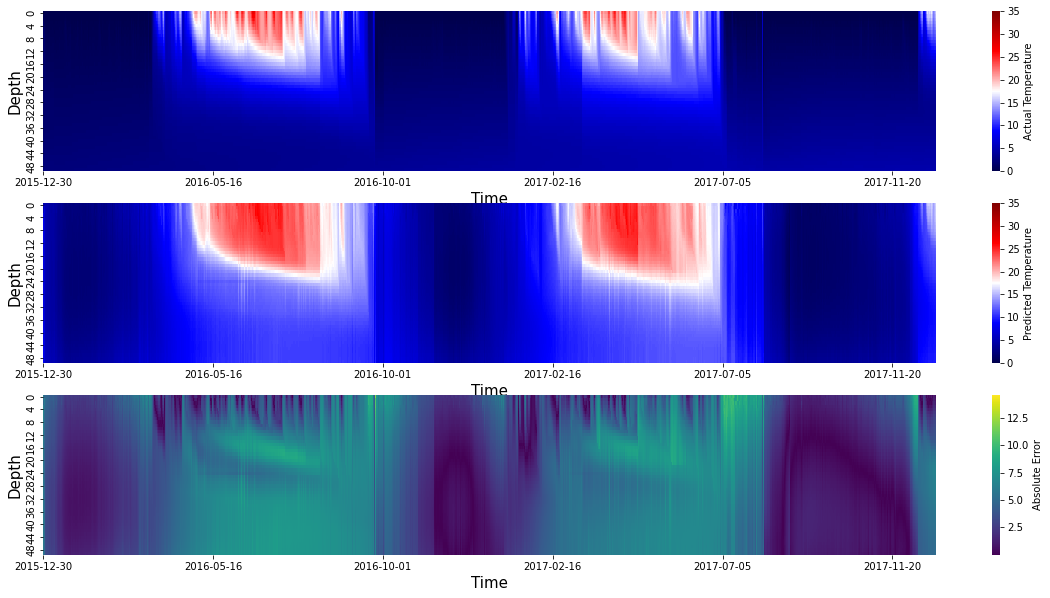

In [34]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

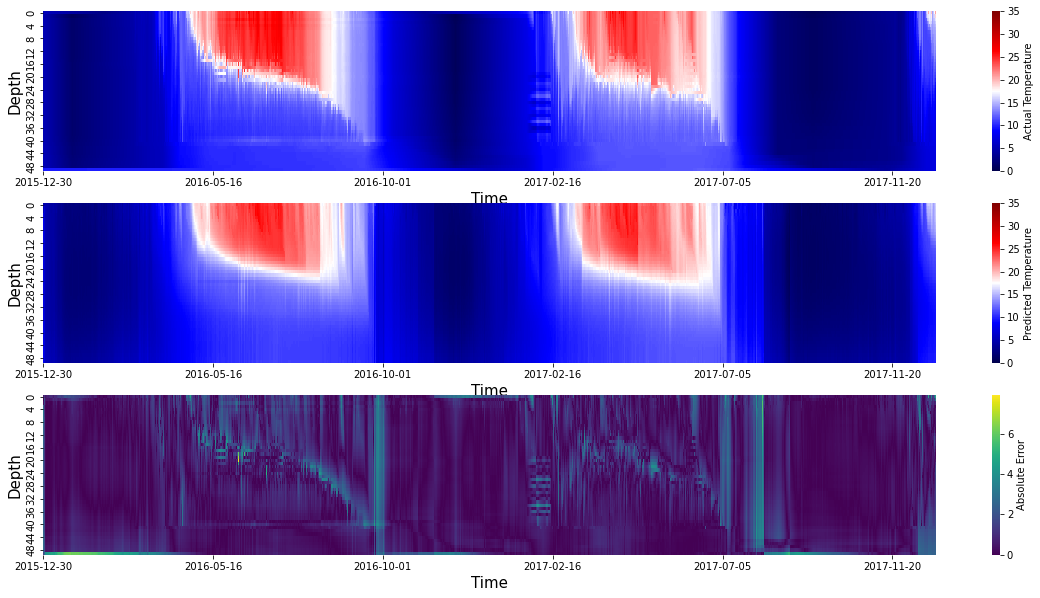

In [35]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

In [36]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.0059419116
RMSE of after m1 0.006902804
RMSE of after m3 5.0987024
RMSE of after m0 0.007157667
RMSE of after m1 0.007972541
RMSE of after m3 5.1577387
RMSE of after m0 0.0047542206
RMSE of after m1 0.005939046
RMSE of after m3 5.198632
RMSE of after m0 0.0051618326
RMSE of after m1 0.0064778053
RMSE of after m3 5.275567
RMSE of after m0 0.005379781
RMSE of after m1 0.006945205
RMSE of after m3 5.3265758
RMSE of after m0 0.005166138
RMSE of after m1 0.00688493
RMSE of after m3 5.3656507
RMSE of after m0 0.005269972
RMSE of after m1 0.0065093883
RMSE of after m3 5.371574
RMSE of after m0 0.0053153355
RMSE of after m1 0.006314988
RMSE of after m3 5.4054017
RMSE of after m0 0.0046447846
RMSE of after m1 0.005735461
RMSE of after m3 5.4498086
RMSE of after m0 0.004503654
RMSE of after m1 0.0058614574
RMSE of after m3 5.499756
RMSE of after m0 0.007767791
RMSE of after m1 0.008159259
RMSE of after m3 5.5035663
RMSE of after m0 0.005861118
RMSE of after m1 0.0065125967
RMS

RMSE of after m1 0.0060641957
RMSE of after m3 6.726881
RMSE of after m0 0.012430295
RMSE of after m1 0.013115964
RMSE of after m3 6.6841683
RMSE of after m0 0.00823705
RMSE of after m1 0.008753587
RMSE of after m3 6.6883926
RMSE of after m0 0.0073705977
RMSE of after m1 0.007822344
RMSE of after m3 6.453361
RMSE of after m0 0.007646391
RMSE of after m1 0.0077457936
RMSE of after m3 6.4060397
RMSE of after m0 0.010148327
RMSE of after m1 0.010304002
RMSE of after m3 6.4800873
RMSE of after m0 0.0060831583
RMSE of after m1 0.006829344
RMSE of after m3 6.584271
RMSE of after m0 0.010573889
RMSE of after m1 0.010777882
RMSE of after m3 6.6717963
RMSE of after m0 0.0067374343
RMSE of after m1 0.0075010043
RMSE of after m3 6.5554633
RMSE of after m0 0.0065398538
RMSE of after m1 0.007208854
RMSE of after m3 6.474311
RMSE of after m0 0.0062801163
RMSE of after m1 0.007158946
RMSE of after m3 6.4151073
RMSE of after m0 0.0064432817
RMSE of after m1 0.0071670907
RMSE of after m3 6.40955
RMSE o

RMSE of after m3 4.9245133
RMSE of after m0 0.0068743955
RMSE of after m1 0.027985027
RMSE of after m3 5.281849
RMSE of after m0 0.0061990884
RMSE of after m1 0.026365085
RMSE of after m3 5.315351
RMSE of after m0 0.0060292934
RMSE of after m1 0.025042884
RMSE of after m3 5.261037
RMSE of after m0 0.0059151067
RMSE of after m1 0.02845197
RMSE of after m3 5.134689
RMSE of after m0 0.005905574
RMSE of after m1 0.037929695
RMSE of after m3 4.940929
RMSE of after m0 0.006334074
RMSE of after m1 0.036127497
RMSE of after m3 4.7422547
RMSE of after m0 0.00627879
RMSE of after m1 0.027393384
RMSE of after m3 4.757116
RMSE of after m0 0.0060770637
RMSE of after m1 0.027056566
RMSE of after m3 4.809733
RMSE of after m0 0.005619161
RMSE of after m1 0.027193282
RMSE of after m3 5.050155
RMSE of after m0 0.0056723664
RMSE of after m1 0.02644495
RMSE of after m3 5.1054616
RMSE of after m0 0.005361864
RMSE of after m1 0.024167784
RMSE of after m3 4.9493594
RMSE of after m0 0.0057812496
RMSE of after

RMSE of after m0 0.03202815
RMSE of after m1 0.103654936
RMSE of after m3 1.5790722
RMSE of after m0 0.035684105
RMSE of after m1 0.13186322
RMSE of after m3 1.6904514
RMSE of after m0 0.04861297
RMSE of after m1 0.18988305
RMSE of after m3 2.352925
RMSE of after m0 0.07928974
RMSE of after m1 0.2012814
RMSE of after m3 2.63083
RMSE of after m0 0.06209704
RMSE of after m1 0.19712926
RMSE of after m3 1.8649489
RMSE of after m0 0.059634257
RMSE of after m1 0.19944134
RMSE of after m3 1.8922294
RMSE of after m0 0.06190334
RMSE of after m1 0.20821567
RMSE of after m3 1.9325709
RMSE of after m0 0.06418137
RMSE of after m1 0.20601286
RMSE of after m3 1.9769914
RMSE of after m0 0.054123033
RMSE of after m1 0.20430648
RMSE of after m3 2.018311
RMSE of after m0 0.048772503
RMSE of after m1 0.20269486
RMSE of after m3 2.040554
RMSE of after m0 0.057070404
RMSE of after m1 0.22015743
RMSE of after m3 2.1092384
RMSE of after m0 0.081837445
RMSE of after m1 0.21378964
RMSE of after m3 2.1775393
RMS

RMSE of after m1 0.005094839
RMSE of after m3 4.4589095
RMSE of after m0 0.008031833
RMSE of after m1 0.008108666
RMSE of after m3 4.524766
RMSE of after m0 0.0074371677
RMSE of after m1 0.00830644
RMSE of after m3 4.452636
RMSE of after m0 0.0057397196
RMSE of after m1 0.0063545913
RMSE of after m3 4.4587817
RMSE of after m0 0.005123499
RMSE of after m1 0.0060511827
RMSE of after m3 4.491239
RMSE of after m0 0.0052820193
RMSE of after m1 0.006419514
RMSE of after m3 4.680208
RMSE of after m0 0.0052316515
RMSE of after m1 0.006476621
RMSE of after m3 4.6486964
RMSE of after m0 0.0038999375
RMSE of after m1 0.0050414153
RMSE of after m3 4.6999903
RMSE of after m0 0.0041096425
RMSE of after m1 0.005642016
RMSE of after m3 4.6956134
RMSE of after m0 0.004508008
RMSE of after m1 0.0057653077
RMSE of after m3 4.7415643
RMSE of after m0 0.0055977283
RMSE of after m1 0.006018032
RMSE of after m3 4.7588234
RMSE of after m0 0.0054250015
RMSE of after m1 0.006210314
RMSE of after m3 4.753423
RMS

RMSE of after m3 6.296024
RMSE of after m0 0.0087410705
RMSE of after m1 0.008810335
RMSE of after m3 6.4330707
RMSE of after m0 0.0076665436
RMSE of after m1 0.008065612
RMSE of after m3 6.5253987
RMSE of after m0 0.0055801175
RMSE of after m1 0.006199817
RMSE of after m3 6.625044
RMSE of after m0 0.0047136894
RMSE of after m1 0.0056969747
RMSE of after m3 6.717204
RMSE of after m0 0.005819869
RMSE of after m1 0.0070684557
RMSE of after m3 6.6315556
RMSE of after m0 0.0059565636
RMSE of after m1 0.0060965903
RMSE of after m3 6.7317553
RMSE of after m0 0.008330602
RMSE of after m1 0.008205334
RMSE of after m3 6.990592
RMSE of after m0 0.006344779
RMSE of after m1 0.007346253
RMSE of after m3 7.014424
RMSE of after m0 0.016740473
RMSE of after m1 0.016645346
RMSE of after m3 6.8180547
RMSE of after m0 0.0056304876
RMSE of after m1 0.006660465
RMSE of after m3 6.711587
RMSE of after m0 0.0045621004
RMSE of after m1 0.006383826
RMSE of after m3 6.6844645
RMSE of after m0 0.0042897114
RMSE

RMSE of after m0 0.008737732
RMSE of after m1 0.08878667
RMSE of after m3 5.728463
RMSE of after m0 0.0068173544
RMSE of after m1 0.08657073
RMSE of after m3 5.9895773
RMSE of after m0 0.006855696
RMSE of after m1 0.086653516
RMSE of after m3 5.890233
RMSE of after m0 0.0064499695
RMSE of after m1 0.08633532
RMSE of after m3 5.8136253
RMSE of after m0 0.0061186217
RMSE of after m1 0.08597734
RMSE of after m3 5.734809
RMSE of after m0 0.006130102
RMSE of after m1 0.08643036
RMSE of after m3 5.721701
RMSE of after m0 0.0063025826
RMSE of after m1 0.08787431
RMSE of after m3 5.6072917
RMSE of after m0 0.005942295
RMSE of after m1 0.0889053
RMSE of after m3 5.5626235
RMSE of after m0 0.005972966
RMSE of after m1 0.089422345
RMSE of after m3 5.557762
RMSE of after m0 0.014698625
RMSE of after m1 0.08700107
RMSE of after m3 5.2082615
RMSE of after m0 0.009943311
RMSE of after m1 0.06820728
RMSE of after m3 5.786385
RMSE of after m0 0.0062671765
RMSE of after m1 0.06444054
RMSE of after m3 6.

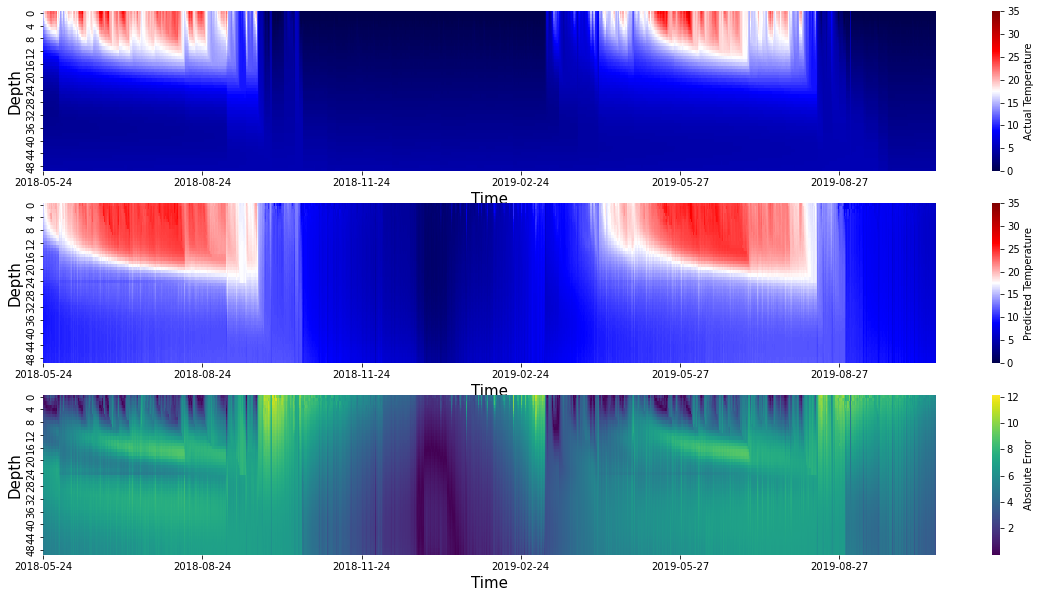

In [37]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

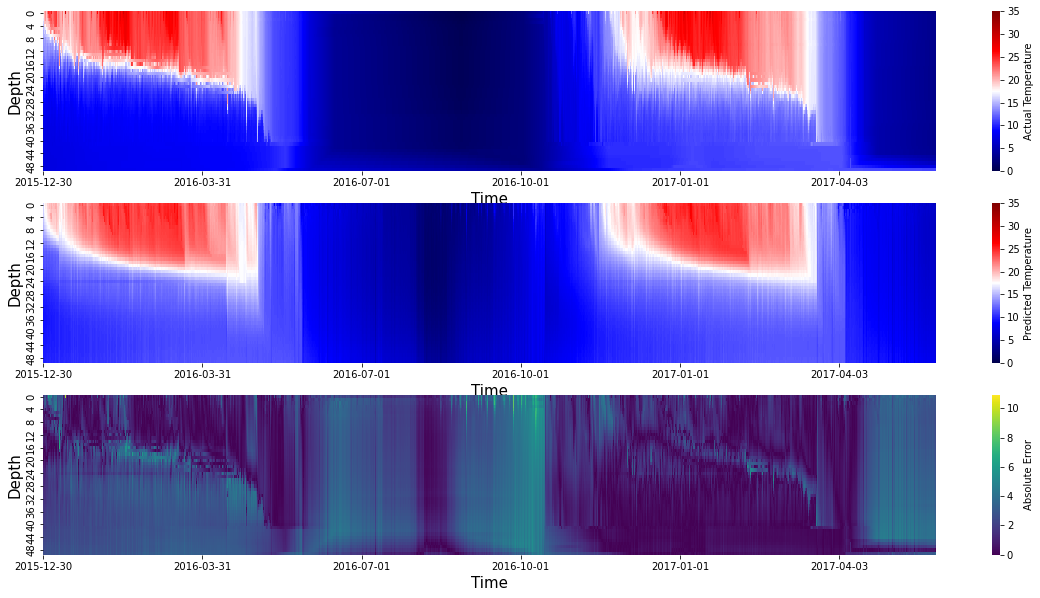

In [38]:
plot_output(test_y_pred, test_y_obs, depth_steps, train_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [39]:
train_rmse, train_l2_err = compute_metrics(heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 4.740115103960621, Train L2 Error: 0.6602285238600879
Test RMSE: 5.605344000950458, Train L2 Error: 0.6843210020628198


## Mixing Model

## Convection Model

## Ice Model

In [40]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.011916424143528238, Train L2 Error: 0.0016585208599914363
Test RMSE: 0.07897739329873596, Train L2 Error: 0.0096342043173161


# Compute Model Similarity after Finetuning

In [41]:
def compute_model_similarity(model1, model2):
    weight1 = []
    weight2 = []
    for param1, param2 in zip(model1.parameters(), model2.parameters()):
        weight1.append(param1.detach().clone().flatten())
        weight2.append(param2.detach().clone().flatten())
    weight1 = torch.cat(weight1, dim=0)
    weight2 = torch.cat(weight2, dim=0)
    
    #Cosine Similarity
    cos = nn.CosineSimilarity(dim=0, eps=1e-8)
    cos_sim = cos(weight1, weight2)
    
    #L2 norm
    l2 = torch.norm((weight1-weight2), p='fro', dim=0)
    
    return cos_sim, l2

In [42]:
heating_model_init = MLP(m0_layers, activation="gelu")
heating_model_init.load_state_dict(m0_checkpoint)
heating_model_init = heating_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heating_model_init, heating_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [43]:
heat_diff_model_init = MLP(m1_layers, activation="gelu")
heat_diff_model_init.load_state_dict(m1_checkpoint)
heat_diff_model_init = heat_diff_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heat_diff_model_init, heat_diff_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 0.8575666546821594
L2 Norm: 5.501893043518066


In [44]:
ice_model_init = MLP(m4_layers, activation="gelu")
ice_model_init.load_state_dict(m4_checkpoint)
ice_model_init = ice_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(ice_model_init, ice_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [45]:
# Freeze all models again and compute finetuned diffusivity values

In [46]:
# Unfreeze diffusion model and finetune it on projected diffusivities

In [47]:
PATH = f"./saved_models/diffusionconvection_model_finetuned.pth"
torch.save(heat_diff_model.state_dict(), PATH)